In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
def EAST_OCR(img_path, 
            min_confidence = 0.5,
            width = 320,
            height = 320,
            east_model_path = '/Volumes/Data/Text_Classification/opencv-text-detection/frozen_east_text_detection.pb'):
    from imutils.object_detection import non_max_suppression
    import numpy as np
    import cv2
    import re
    
    image = cv2.imread(img_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)
    #resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]
    
    # load the pre-trained EAST text detector
    net = cv2.dnn.readNet(east_model_path)
    
    # construct a blob from the image and then perform a forward pass of 
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W,H),
                                (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores and geometrical data to derive bounding box coordinates
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        # loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue
                
            # compute the offset factor as our resulting feature maps will be 
            # 4* smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            # use the geometry volume to derive the width and height of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    print boxes.shape
    words = []
    
#     start = time.time()
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box based on respective ratio
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        
        # OCR by pytesseract
        import pytesseract
        extraPixelsX = 0.99
        extraPixelsY = 0.99
        cropped_image = orig[int(startY*extraPixelsY):int(endY/extraPixelsY), int(startX*extraPixelsX):int(endX/extraPixelsX)]
#         config = ('-l eng --oem 3 --psm 6')
#         text = pytesseract.image_to_string(cropped_image, config=config).encode('utf-8')
        text = pytesseract.image_to_string(cropped_image)
        
        word = re.sub('[^a-z]+', '', text.lower())
        if len(word) > 1 and len(text) <100: 
            words.append(word)
#     end = time.time()
#     print ('OCR takes {:.4f} seconds'.format(end-start))

            cv2.rectangle(orig, (startX, startY), (endX, endY), (0,255,0),2)
#         cv2.putText(img=orig, 
#                     text=str(word), 
#                     org=(startX,startY),
#                     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#                     fontScale=1,
#                     color=(0,255,0))
        
    new_filename = img_path.split('.')[0] + '-EAST.' + '.'.join(path.split('.')[1:])
    cv2.imwrite(new_filename, orig)    
    plt.figure(figsize=(10,15))
    plt.imshow(orig)
    
    return ' '.join(words)
        
             
        

In [152]:
from google.cloud import vision
from google.cloud.vision import types
import io
import re
import matplotlib.pyplot as plt
import cv2

client = vision.ImageAnnotatorClient()
# def extract_text_features_simple(path):
#     img = cv2.imread(path)
#     image = vision.types.Image(content=cv2.imencode('.jpg', img)[1].tostring())
#     response = client.text_detection(image=image)
#     texts = response.text_annotations 
#     Words = []
#     for i in range(len(texts)):
#         text = texts[i].description
#         word = re.sub('[^a-z]+', '', text.lower())
#         if len(word) > 1 and len(text) <100: 
#             Words.append(word)
#     return ' '.join(Words)

def extract_text_features_no_combine(path):
    img = cv2.imread(path)
    img_cropped = img.copy()
    image = vision.types.Image(content=cv2.imencode('.jpg', img_cropped)[1].tostring())
    response = client.text_detection(image=image)
    texts = response.text_annotations
    Words = []
    for i in range(len(texts)):
        text = texts[i].description
        word =re.sub('[^a-z]+', '', text.lower())
        if len(word) > 1 and len(text) < 100: 
            vertices = ([(vertex.x, vertex.y)
                        for vertex in texts[i].bounding_poly.vertices])
            startX = vertices[0][0]
            startY = vertices[0][1]
            endX = vertices[2][0]
            endY = vertices[2][1]
            Words.append(word.lower())
            cv2.rectangle(img_cropped, (startX, startY),(endX, endY), (0,255,0),2)
    new_filename = path.split('.')[0] + '-google_vision.' + '.'.join(path.split('.')[1:])
    cv2.imwrite(new_filename, img_cropped)
    plt.figure(figsize=(10,15))
    plt.imshow(img_cropped)
    return ' '.join(Words)

(49, 4)


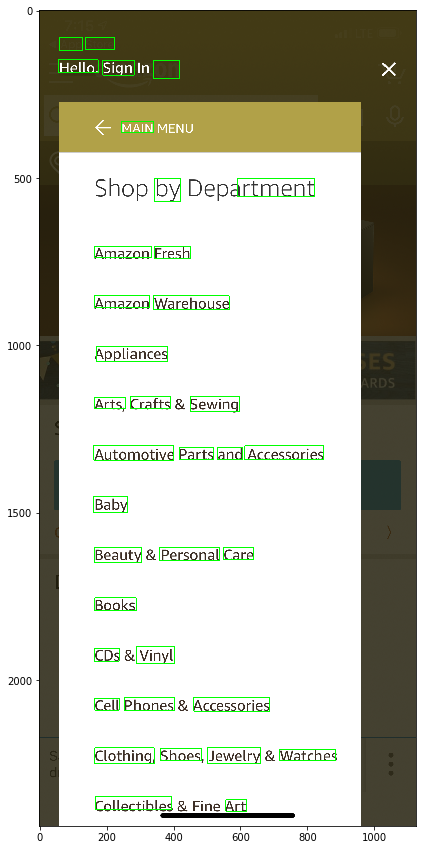

In [155]:
path = '/Users/yinlinfu/Desktop/examples/categories_1.PNG'
# path = '/Users/yinlinfu/Desktop/examples/Screenshot_1549666043.png'
word_1 = EAST_OCR(img_path = path, 
            min_confidence = 0.6,
            width = 1280,
            height = 1920,
            east_model_path = '/Volumes/Data/Text_Classification/opencv-text-detection/frozen_east_text_detection.pb')


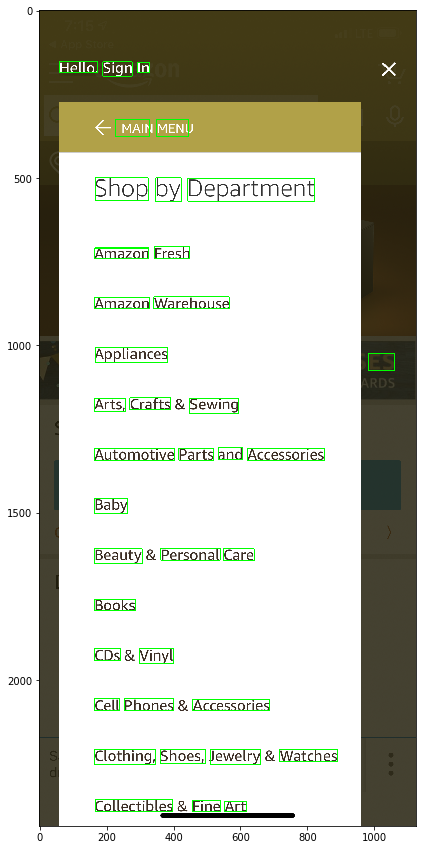

In [156]:
word_google = extract_text_features_no_combine(path)

In [157]:
print word_1 
print '-----------------------'
print word_google

cell main accessories beauty fresh hello sign accessories phones watches collectibles arta warehouse books appliances jewelry personal automotive parts shoes arts and cds care amazon vinyl ywtment clothing sewing amazon crafts baby store app on by
-----------------------
hello sign in main menu shop by department amazon fresh amazon warehouse appliances es arts crafts sewing automotive parts and accessories baby beauty personal care books cds vinyl cell phones accessories clothing shoes jewelry watches collectibles fine art


In [158]:
list1 = list(word_1.split(' '))
list2 = list(word_google.split(' '))
common = list(set(list1).intersection(list2))

In [159]:
print len(list1)
print len(list2)
print len(common)

36
38
29


In [160]:
set(list1) - set(common)

{u'app', u'arta', u'on', u'store', u'ywtment'}

In [161]:
set(list2) - set(common)

{u'art', u'department', u'es', u'fine', u'in', u'menu', u'shop'}

In [88]:
len(set(list2))

24